In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from matplotlib import image
from pathlib import Path

from PIL import Image
from numpy import asarray

In [2]:
isic_input_path = './../../../dataset/ISIC2018_Task1-2_Training_Input_x2/*.jpg'
isic_groundTruth_path = './../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2/*.png'

In [3]:
isic_input = sorted(glob.glob(isic_input_path))
isic_groundTruth = sorted(glob.glob(isic_groundTruth_path))

DATASET_SIZE = len(isic_input)
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256
IMG_CHANNELS = 4

In [4]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)


In [5]:
## Splitting up the dataset for training, validation, and testing

full_ds = tf.data.Dataset.from_tensor_slices((isic_input, isic_groundTruth))
full_ds = full_ds.shuffle(DATASET_SIZE, reshuffle_each_iteration=False)

train_ds = full_ds.take(train_size)

# skip the dataset for train
test_ds = full_ds.skip(train_size)

val_ds = full_ds.skip(val_size)
test_ds = full_ds.take(test_size)

In [6]:
def decode_img(image):
    image = tf.image.decode_jpeg(image, channels=3)
    # resize the image 256*256 
    image =  tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Standardise values to be in the [0, 1] range.
    image = tf.cast(image, tf.float32) / 255.0
    
    return image
    
def decode_label(label):
    label = tf.image.decode_png(label, channels=1)
    # Resize the image to the desired size.
    label =  tf.image.resize(label, [IMG_HEIGHT, IMG_WIDTH])
    
    label = tf.round(label / 255.0)
    label = tf.cast(label, tf.float32)
    return label

def decode_label_with_onehot(label):
    label = tf.image.decode_png(label, channels=1)
    # Resize the image to the desired size.
    label =  tf.image.resize(label, [IMG_HEIGHT, IMG_WIDTH])
    
    one_hot_map = []

    for clr in [0, 255]:
        class_map = tf.equal(label, clr)
        class_map = tf.reduce_all(class_map,axis=-1)
        one_hot_map.append(class_map)
    
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)
    return one_hot_map

    
def process_data(image, label):
    image = tf.io.read_file(image)
    image = decode_img(image)
    
    label = tf.io.read_file(label)
    label = decode_label(label)
    # label = decode_label_with_onehot(label)
    
    return image, label   

In [7]:
# Use Dataset.map to apply this transformation.
processed_train_ds = train_ds.map(process_data)
processed_val_ds = val_ds.map(process_data)
processed_test_ds = test_ds.map(process_data)

Image shape: b'./../../../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000474.jpg'
Label: b'./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0000474_segmentation.png'

Image shape: (192, 256, 3)
Label: (192, 256, 1)
1


(-0.5, 255.5, 191.5, -0.5)

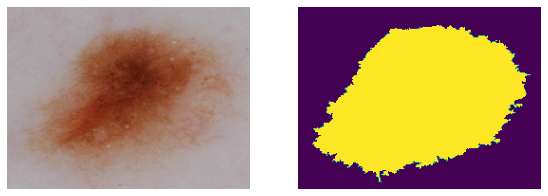

In [8]:
for image, label in train_ds.take(1):
    print('Image shape:', image.numpy())
    print('Label:', label.numpy())
print()

## Getting the input and output size
input_size = (0, 0, 0)
output_class_num = 0
for image, label in processed_train_ds.take(1):
    input_size = image.numpy().shape
    output_class_num = label.numpy().shape[2]
    print('Image shape:', image.numpy().shape)
    print('Label:', label.numpy().shape)
plt.figure(figsize=(20, 10))

print(output_class_num)

# print(label)
plt.subplot(1, 4, 1)
plt.imshow(image.numpy())
plt.axis('off')

plt.subplot(1, 4, 2)
if (output_class_num > 1):
    plt.imshow(tf.argmax(label.numpy(), axis=2))
else:
    plt.imshow(label.numpy())
plt.axis('off')

In [9]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def display(image, ground_truth, prediction, num):
    plt.figure(figsize=(20, 20))
    colors = ['black', 'green', 'red']
    for i in range(num):
        plt.subplot(4, 3, 3*i+1)
        plt.imshow(image[i])
        title = plt.title('The actual image')
        plt.setp(title, color=colors[0])
        plt.axis('off')
        
        plt.subplot(4, 3, 3*i+2)
        if (output_class_num > 1):
            plt.imshow(tf.argmax(ground_truth[i], axis=2))
        else:
            plt.imshow(ground_truth[i])
        title = plt.title('Ground truth image segmentation')
        plt.setp(title, color=colors[1])
        plt.axis('off')
        
        plt.subplot(4, 3, 3*i+3)
        if (output_class_num > 1):
            plt.imshow(tf.argmax(prediction[i], axis=2))
        else:
            plt.imshow(prediction[i] > 0.5)
        title = plt.title('Prediction image segmentation')
        plt.setp(title, color=colors[2])
        plt.axis('off')

        print("DICE SIMILARITY FOR INPUT {}: {}".format(i, dice_coef(ground_truth[i], prediction[i])))
    plt.show()

    
def show_predictions(processed_test_ds, num=3):
    image_test_batch, label_test_batch = next(iter(processed_test_ds.batch(num)))
    prediction = model.predict(image_test_batch)
    display(image_test_batch, label_test_batch, prediction, num)

    
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(processed_test_ds)

In [10]:
from model import *

## Use this one for the original unet model
# model = unet(output_class_num, input_size)

## Use this one for the improved unet model
model = improved_unet(output_class_num, input_size)

print("Loss Function: dice similarity coefficient")
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=['accuracy', dice_coef])

print()
model.summary()

Activation function: sigmoid
Loss Function: dice similarity coefficient

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 192, 256, 16) 32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 192, 256, 16) 0           instance_normalization[0][0]     
_____________________

DICE SIMILARITY FOR INPUT 0: 0.9404114484786987
DICE SIMILARITY FOR INPUT 1: 0.9328176379203796
DICE SIMILARITY FOR INPUT 2: 0.90794438123703


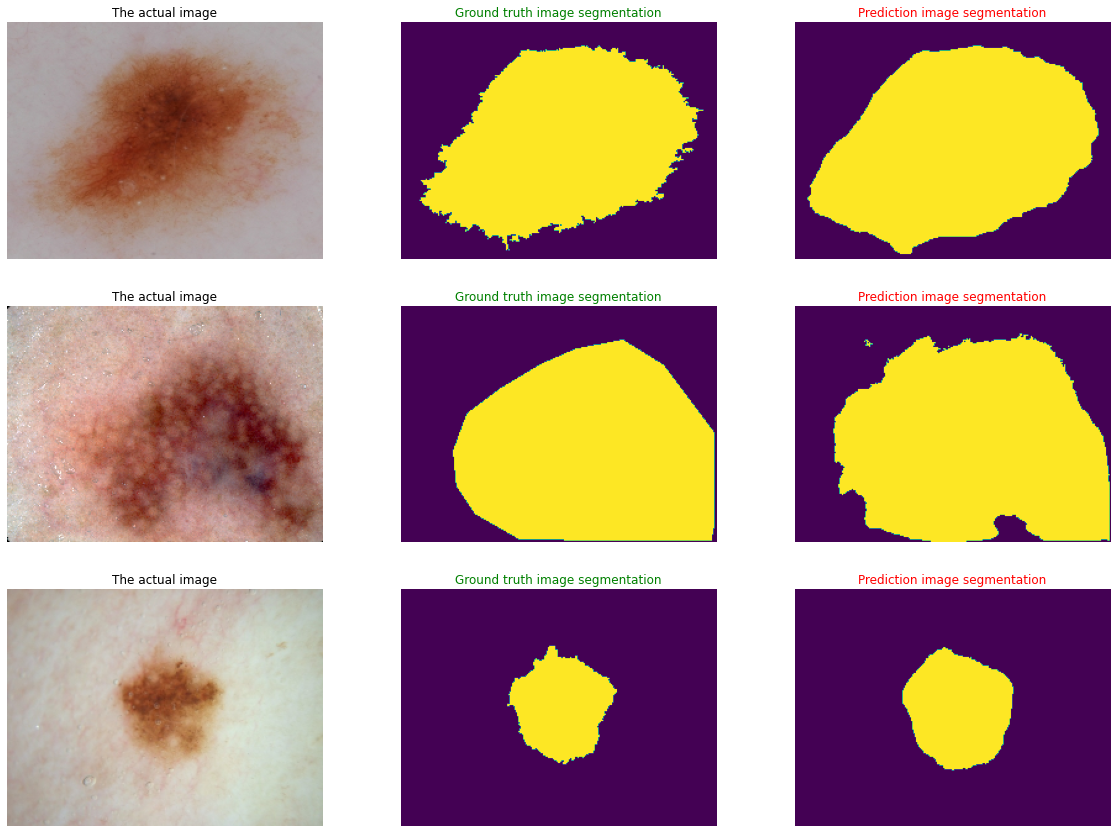

57/57 [==============================] - 178s 3s/step - loss: 0.0926 - accuracy: 0.9492 - dice_coef: 0.9074 - val_loss: 0.1393 - val_accuracy: 0.9255 - val_dice_coef: 0.8607


In [11]:
history = model.fit(processed_train_ds.batch(BATCH_SIZE), 
                    validation_data=processed_val_ds.batch(BATCH_SIZE), 
                    epochs=10, callbacks=[DisplayCallback()])

In [12]:
results = model.evaluate(processed_test_ds.batch(BATCH_SIZE), verbose=1)
print(results)

9/9 [==============================] - 11s 1s/step - loss: 0.1419 - accuracy: 0.9297 - dice_coef: 0.8581
[0.1418547100490994, 0.9296582, 0.85814524]


In [13]:
image_test_batch, label_test_batch = next(iter(processed_test_ds.batch(test_size)))
predictions = model.predict(image_test_batch)

print(predictions.shape)
# plt.imshow(predictions[2])

(259, 192, 256, 1)


In [17]:
bad_dsc = 0
total_dsc = 0
length = predictions.shape[0]
min_dsc = 0.8
print("DSC BELOW {}:".format(min_dsc))
for i in range(length):
    dsc = dice_coef(label_test_batch[i], predictions[i])
    if dsc < min_dsc:
        bad_dsc += 1
        print("  Index {}, dsc is {}".format(i, dsc))
    total_dsc += dsc

print()
print("There are {} bad dsc (< 0.8) out of {}".format(bad_dsc, length))
print("There are {} good dsc (>= 0.8) out of {}".format((length-bad_dsc), length))
print("Average dsc: ", total_dsc/length)

DSC BELOW 0.8:
  Index 14, dsc is 0.6411579251289368
  Index 19, dsc is 0.6381526589393616
  Index 23, dsc is 0.5374658107757568
  Index 29, dsc is 0.6463614106178284
  Index 34, dsc is 0.6099135279655457
  Index 37, dsc is 0.5764310359954834
  Index 43, dsc is 0.42628926038742065
  Index 44, dsc is 0.4549385607242584
  Index 45, dsc is 0.3402889668941498
  Index 47, dsc is 0.11800719052553177
  Index 55, dsc is 0.6003413796424866
  Index 58, dsc is 0.7623339295387268
  Index 66, dsc is 0.6357090473175049
  Index 74, dsc is 0.7627314329147339
  Index 77, dsc is 0.5821884274482727
  Index 83, dsc is 0.6289951801300049
  Index 85, dsc is 0.772200345993042
  Index 90, dsc is 0.7319735288619995
  Index 94, dsc is 0.712157666683197
  Index 102, dsc is 0.7851937413215637
  Index 103, dsc is 0.6167271733283997
  Index 104, dsc is 0.2009550929069519
  Index 107, dsc is 0.6735878586769104
  Index 116, dsc is 0.7545134425163269
  Index 117, dsc is 0.3267478942871094
  Index 119, dsc is 0.7662551

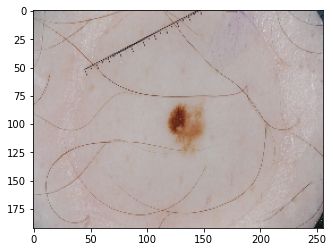

In [15]:
# plt.imshow(predictions[1] > 0.5)
plt.imshow(image_test_batch[100])
# plt.imshow(tf.argmax(label_test_batch[100], axis=2))
# plt.imshow(predictions[100][:,:,1] > 0.5)

In [16]:
ds = test_ds.as_numpy_iterator()
#     print('Image shape:', image.numpy())
#     print('Label:', label.numpy())
print(list(ds)[100])

(b'./../../../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0012887.jpg', b'./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0012887_segmentation.png')
